In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Markov Decision Process (MDP)

An MDP is defined by the tuple $\langle \mathcal{S}, \mathcal{A}, \mathcal{T}, \mathcal{R}, \gamma  \rangle$ where,

$\mathcal{S}$ is the state space

$\mathcal{A}$ is the action space

$\mathcal{T}$ is the transition model

$\mathcal{R}$ is the reward model

$\gamma$ is the discount factor


## State Space

In [2]:
TIME_HORIZON = 10
num_damage_states = 5

num_states = TIME_HORIZON * num_damage_states

# Compute state space
state_space = {}
key = 1

for time in range(1, TIME_HORIZON+1):
    for state in range(1, num_damage_states+1):
        state_space[key] = (time, state)
        key += 1

## Action Space

The action space has 3 actions and we carry out these actions at the beginning of the time-step

0: Do nothing - component undergoes deterioration due to the environment

1: Repair - component moves back by 1 damage state (+undergoes deterioration due to the environment)

2: Replace - component is replaced (+undergoes deterioration due to the environment)

In [3]:
DO_NOTHING = 0
MINOR_REPAIR = 1
REPLACE = 2

action_space = [DO_NOTHING, MINOR_REPAIR, REPLACE]

num_actions = len(action_space)

## Transition Model

In [4]:
TRANSITION_MODEL = np.array([[0.7, 0.3, 0.0, 0.0, 0.0],
                             [0.0, 0.6, 0.4, 0.0, 0.0],
                             [0.0, 0.0, 0.5, 0.5, 0.0],
                             [0.0, 0.0, 0.0, 0.1, 0.9],
                             [0.0, 0.0, 0.0, 0.0, 1.0]])

## Reward model

In [5]:
REPAIR_COST = -25
REPLACE_COST = -50

REWARDS = [0, REPAIR_COST, REPLACE_COST]

PENALTY = -500

## Discount Factor

In [6]:
DISCOUNT_FACTOR = 0.9

In [7]:
def MDP_model(current_state, action):

    """_summary_

    Returns
    -------
    current_state: 
        _description_

    action:
        
    """    

    current_time, current_damage_state = current_state
    next_time = current_time + 1
    
    output = []

    # action = 'do-nothing'
    # damage state does not change

    # action = 'minor-repair'
    if action == 1:
        # move back by one state
        # but not lower than 1
        # but no minor repair for failure
        if current_damage_state != 5:
            current_damage_state = max(1, current_damage_state-1)

    # action = 'replace'
    elif action == 2:
        # replacing leads to initial undamaged state
        current_damage_state = 1

    for next_damage_state in range(1, num_damage_states+1):

        next_state = (next_time, next_damage_state)
        prob = TRANSITION_MODEL[current_damage_state-1, next_damage_state-1]
        reward = REWARDS[action]

        if next_damage_state == 5:
            reward += PENALTY

        output.append((prob, next_state, reward))

    return output

In [8]:
MDP_model(state_space[5], 2)

[(0.7, (2, 1), -50),
 (0.3, (2, 2), -50),
 (0.0, (2, 3), -50),
 (0.0, (2, 4), -50),
 (0.0, (2, 5), -550)]

## Value Iteration

In [9]:
# Initialise values of all states with 0
value_function = np.zeros(num_states)
q_values = np.zeros((num_states, len(action_space)))
optimal_action = np.zeros(num_states, dtype=int)

delta_threshold = 1e-5
delta = 10

# Fixed point iteration
while delta > delta_threshold:
    delta = 0

    # ignore terminal states, since value is 0
    for idx_state in range(num_states-num_damage_states):

        state = state_space[idx_state+1]
        old_value = value_function[idx_state]

        # store Q values of all actions
        for idx_action, action in enumerate(action_space):
            q_val = 0
            for tuple in MDP_model(state, action):
                prob, next_state, reward = tuple
                idx_next_state = (next_state[0]-1) * 5 + next_state[1]-1
                q_val += prob * (reward + DISCOUNT_FACTOR * value_function[idx_next_state])
            q_values[idx_state, idx_action] = q_val
                
        # value_function[state] = max(q_values)
        idx = np.random.choice(np.flatnonzero(q_values[idx_state, :] == max(q_values[idx_state, :])))
        optimal_action[idx_state]= idx
        value_function[idx_state] = q_values[idx_state, idx]

        delta = max([delta, np.abs(old_value - value_function[idx_state])])

In [10]:
reshaped_value_func = value_function.reshape(TIME_HORIZON, num_damage_states)

In [11]:
optimal_action.reshape(TIME_HORIZON, num_damage_states)

array([[0, 0, 0, 2, 2],
       [0, 0, 0, 2, 2],
       [0, 0, 0, 2, 2],
       [0, 0, 0, 2, 2],
       [0, 0, 0, 2, 2],
       [0, 0, 0, 2, 2],
       [0, 0, 0, 1, 2],
       [0, 0, 0, 1, 2],
       [0, 0, 0, 1, 2],
       [0, 0, 0, 0, 0]])

In [12]:
print(f"Value of states: [time_horizon, num_states] \n {np.around(value_function.reshape(TIME_HORIZON, num_damage_states),3)}")

Value of states: [time_horizon, num_states] 
 [[-16.602 -33.016 -49.573 -66.602 -66.602]
 [-13.485 -30.024 -46.677 -63.485 -63.485]
 [-10.054 -26.484 -43.672 -60.054 -60.054]
 [ -6.519 -22.024 -40.531 -56.519 -56.519]
 [ -3.357 -16.312 -36.711 -53.357 -53.357]
 [ -1.094  -9.882 -30.488 -51.094 -51.094]
 [  0.     -4.05  -21.375 -46.375 -50.   ]
 [  0.      0.    -11.25  -36.25  -50.   ]
 [  0.      0.      0.    -25.    -50.   ]
 [  0.      0.      0.      0.      0.   ]]


## Plots

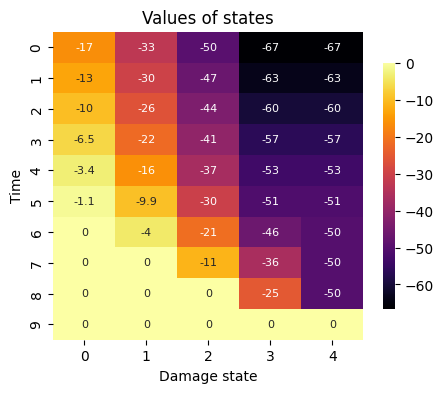

In [13]:
_value_func_2d = value_function.reshape(TIME_HORIZON, num_damage_states)
_optimal_actions_2d = optimal_action.reshape(TIME_HORIZON, num_damage_states)

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(_value_func_2d, cmap="inferno", annot=_value_func_2d, annot_kws={'fontsize': 8}, cbar_kws={"shrink": .8})

ax.set_xlabel('Damage state')
ax.set_ylabel('Time')
ax.set_title('Values of states')

plt.show()